# Pydy Tuesday 22-07-2025 - MTA Permanent Art Catalog (New York)

### 1. Import Libraries

In [1]:
import sys
import pydytuesday
import pandas as pd

# For Data Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For wordcloud
from wordcloud import WordCloud, STOPWORDS
# For filtering word counts
from collections import Counter

# For HTML parsing and image viewing
import requests
import PIL
from PIL import Image
from io import BytesIO
import math
import bs4
from bs4 import BeautifulSoup

In [2]:
print("Python:", sys.version)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)

print("\n")
print("PIL:", PIL.__version__)
print("requests:", requests.__version__)
print("bs4:", bs4.__version__)


Python: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
pandas: 2.3.0
matplotlib: 3.6.2
seaborn: 0.13.2


PIL: 10.4.0
requests: 2.32.3
bs4: 4.13.4


### 2.a. Load Data from the official pydytuesday repo

In [3]:
# Use date to fetch the files for that week
pydytuesday.get_date('2025-07-22')

Trying to fetch README from: https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2025/2025-07-22/readme.md
Successfully fetched README from: https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2025/2025-07-22/readme.md
Successfully saved Andors_NYCT_Kings_01_RhodaAndors.png to d:\SAUVIK\Projects\Pydy_Tuesdays\Pydy_22072025\Andors_NYCT_Kings_01_RhodaAndors.png
Successfully saved meta.yaml to d:\SAUVIK\Projects\Pydy_Tuesdays\Pydy_22072025\meta.yaml
Successfully saved mta_art.csv to d:\SAUVIK\Projects\Pydy_Tuesdays\Pydy_22072025\mta_art.csv
Successfully saved station_lines.csv to d:\SAUVIK\Projects\Pydy_Tuesdays\Pydy_22072025\station_lines.csv


### 2.b. Load data into dataframe using Pandas and do initial exploration

In [4]:
# Load datasets using Pandas 
mta_art = pd.read_csv('mta_art.csv')
station_lines = pd.read_csv('station_lines.csv')

# Store all the files in a dictionary
datafiles = {
    "mta_art": mta_art,
    "station_lines": station_lines
}

# Print info for all the files
for filename, df in datafiles.items():
    print(f" {filename} Info: \n")
    print(df.info())
    print("\n" + "-"*60 + "\n")

 mta_art Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   agency           381 non-null    object
 1   station_name     381 non-null    object
 2   line             378 non-null    object
 3   artist           381 non-null    object
 4   art_title        381 non-null    object
 5   art_date         381 non-null    int64 
 6   art_material     381 non-null    object
 7   art_description  378 non-null    object
 8   art_image_link   376 non-null    object
dtypes: int64(1), object(8)
memory usage: 26.9+ KB
None

------------------------------------------------------------

 station_lines Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   agency        720 non-null    object
 1   station

In [5]:
# Set option to view data in single line
pd.set_option('display.width', 1000)

# See statistical info of all features (including categorical features) of 1st dataframe - mta_art
print(mta_art.describe(include='all'))

       agency    station_name line             artist art_title     art_date   art_material                                    art_description                                     art_image_link
count     381             381  378                381       381   381.000000            381                                                378                                                376
unique      6             309  113                334       357          NaN            183                                                359                                                347
top      NYCT  Times Sq-42 St    6  Kathleen McCarthy  Untitled          NaN  Faceted glass  Five Points of Observation, sited on the platf...  https://new.mta.info/agency/arts-design/collec...
freq      293               7   20                  5         5          NaN             33                                                  5                                                  5
mean      NaN             NaN 

In [6]:
# See statistical info of the 2nd dataframe - station_lines
print(station_lines.describe())

       agency    station_name line
count     720             720  720
unique      4             306   58
top      NYCT  Times Sq-42 St    2
freq      635              66   46


In [7]:
# See data samples from both dataframes
print("\n mta_art sample rows:\n", mta_art.head())
print("\n station_lines sample rows:\n", station_lines.head())


 mta_art sample rows:
   agency station_name   line           artist                  art_title  art_date                         art_material                                    art_description                                     art_image_link
0   NYCT     Clark St    2,3         Ray Ring       Clark Street Passage      1987                  Terrazzo floor tile  The first model that Brooklyn-born artist Ray ...  https://new.mta.info/agency/arts-design/collec...
1   NYCT       125 St  4,5,6  Houston Conwill            The Open Secret      1986                 Bronze - polychromed  The Open Secret, in the 125th Street and Lexin...  https://new.mta.info/agency/arts-design/collec...
2   NYCT     Astor Pl      6    Milton Glaser                   Untitled      1986              Porcelain enamel murals  Milton Glaser, best known for his work in grap...  https://new.mta.info/agency/arts-design/collec...
3   NYCT    Kings Hwy    B,Q     Rhoda Andors  Kings Highway Hieroglyphs      1987     P

From the above initial exploration of the two dataframes, it is observed that the 'station_lines' dataframe is a granular version of the 'line' column from the 'mta_art' dataframe. So at this point, there is no need to merge the data unless we want to specifically look into the 'line' data. For now, let's use only the 'mta_art' dataframe for further analysis.

### 3. Data Pre-processing - Removal of duplicates

In [8]:
# Check for duplicates using a combination of the fields 'station_name', 'artist', art_title')
dup_key = mta_art.duplicated(subset=['station_name', 'artist', 'art_title'])
print("Duplicates by station, artist, and title:", dup_key.sum())
print(mta_art[dup_key].head())

Duplicates by station, artist, and title: 3
          agency             station_name            line              artist              art_title  art_date         art_material                                    art_description                                     art_image_link
266  Metro-North            Croton-Harmon          Hudson      Corinne Ulmann  Croton-Harmon Station      2016  Glass mosaic, vinyl  "Croton-Harmon Station" is a series of site sp...  https://new.mta.info/agency/arts-design/collec...
290         NYCT  Cathedral Pkwy (110 St)  Port Jefferson  Christopher Wynter              Migration      2018         Glass mosaic  As part of the 2018 station improvements, arti...  https://new.mta.info/agency/arts-design/collec...
344         NYCT                    86 St               R         Amy Bennett                Heydays      2021         Glass mosaic  A glass mosaic mural installed within the mezz...  https://new.mta.info/agency/arts-design/collec...


In [9]:
# Drop duplicates
mta_art = mta_art.drop_duplicates(subset=['station_name', 'artist', 'art_title'], keep='first')

# Re-check
print(mta_art.info())

<class 'pandas.core.frame.DataFrame'>
Index: 378 entries, 0 to 380
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   agency           378 non-null    object
 1   station_name     378 non-null    object
 2   line             375 non-null    object
 3   artist           378 non-null    object
 4   art_title        378 non-null    object
 5   art_date         378 non-null    int64 
 6   art_material     378 non-null    object
 7   art_description  375 non-null    object
 8   art_image_link   373 non-null    object
dtypes: int64(1), object(8)
memory usage: 29.5+ KB
None


### 4. Exploratory Data Analysis

In [10]:
# Check how many unique agencies are there and what are they
print("Agencies: ", mta_art['agency'].unique())

Agencies:  ['NYCT' 'Metro-North' 'LIRR' 'B&T' 'MTA Bus Company' 'SIR']


### 4.a. Agency-wise count of artworks

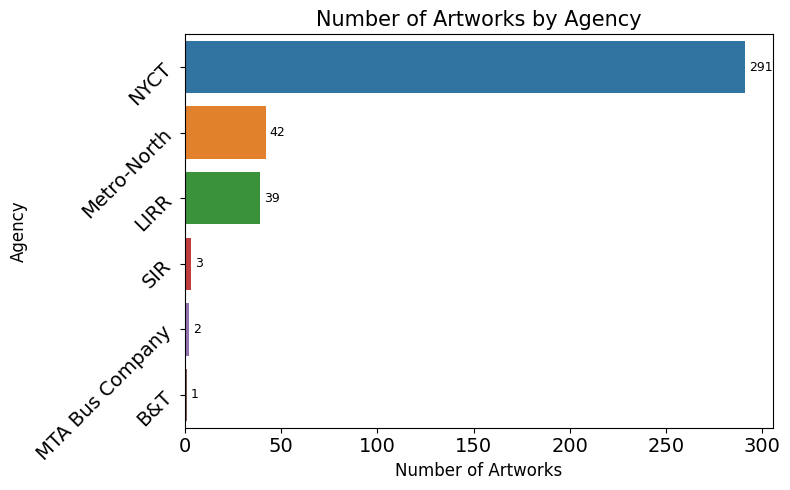

In [11]:
# Count artworks by agencies
agency_counts = mta_art['agency'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
# sns.countplot(data=mta_art, y='agency', order=mta_art['agency'].value_counts().index, palette='Set2', hue='agency', legend=False)

# Barplot
ax = sns.barplot(
    y=agency_counts.index,
    x=agency_counts.values,
    palette='tab10', 
    hue=agency_counts.index,
    legend=False
)

# Add annotations
for i, v in enumerate(agency_counts.values):
    ax.text(v + 2, i, str(v), color='black', va='center', fontsize=9)

# Add plot specifications
plt.title('Number of Artworks by Agency', fontsize=15)
plt.xlabel('Number of Artworks', size=12)
plt.ylabel('Agency', size=12)
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
plt.tight_layout()
plt.show()

Observation:  
- NYCT has a clear majority as it has the maximum number of artworks and leads by a huge margin than the others.  
- Metro-North and LIRR have noticeable number of artworks.
- SIR, MTA Bus Company, and B&T have very few (less than 5) artworks each.

### 4.b.i. Exploring the most widely used art material by using a Wordcloud

In [12]:
# Do some text preprocessing for 'art_material' like drop nulls, convert to lowercase.
materials_text = " ".join(mta_art['art_material'].dropna().str.lower().tolist())

# Form a wordcloud to see the most frequent words from the art material text
wordcloud = WordCloud(width=900, height=500,
                      background_color='white',
                      stopwords=STOPWORDS,
                      colormap='plasma').generate(materials_text)

# Plot it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word-Cloud of Art Materials', fontsize=16)
plt.show()


Observation:  
- Lots of art materials appear on the wordcloud, with many overlapping material categories like [glass, laminated glass, faceted glass, glass mosaic], [steel, stainless steel].
- Some grouping may be beneficial to show up the major categories like - Glass, Steel, Mosaic, Bronze etc. to get more clarity on the wordcloud. 

### 4.b.ii. Art Material Wordcloud - modified with grouping

C:\Users\SAUMITA\AppData\Local\Temp\ipykernel_5792\2277382243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_art['art_material_clean'] = mta_art['art_material'].str.lower().str.strip()
C:\Users\SAUMITA\AppData\Local\Temp\ipykernel_5792\2277382243.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_art['material_category'] = mta_art['art_material_clean'].apply(categorise_material)


art_material_clean
faceted glass                           50
glass mosaic                            47
laminated glass                         46
stainless steel                         15
ceramic mosaic                          11
glass and ceramic mosaic                 6
bronze                                   6
copper wire mesh and stainless steel     5
mosaic                                   4
glass or ceramic mosaic                  4
Name: count, dtype: int64


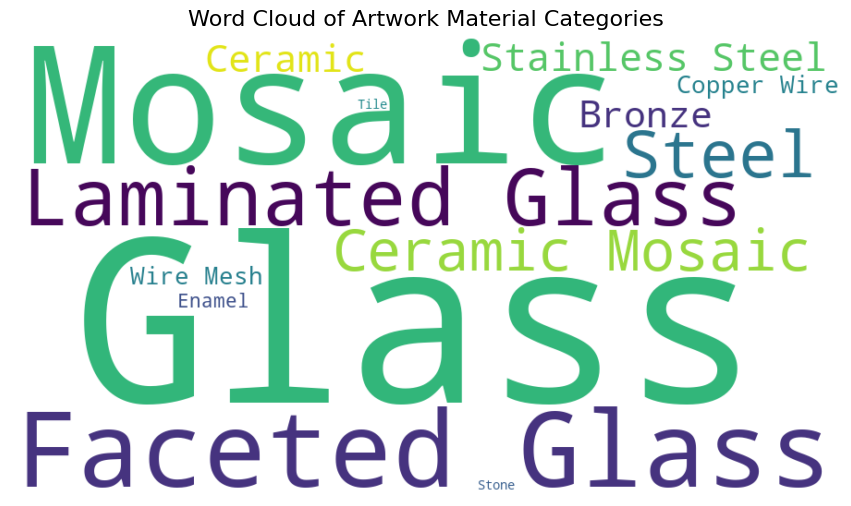

In [13]:
# Normalise
mta_art['art_material_clean'] = mta_art['art_material'].str.lower().str.strip()

# Count frequency of full materials
material_freq = mta_art['art_material_clean'].value_counts()
print(material_freq.head(10))

# Keep top N phrases
top_n = 10
top_phrases = material_freq.head(top_n).index.tolist()

# Keyword fallback
keywords = ['glass', 'mosaic', 'ceramic', 'bronze', 'steel', 'enamel', 'tile', 'stone', 'wood']

# Function for categorising material
def categorise_material(text):
    if text in top_phrases:
        return text.title()  # Keep exact phrase for top
    for kw in keywords:
        if kw in text:
            return kw.capitalize()
    return 'Other'

mta_art['material_category'] = mta_art['art_material_clean'].apply(categorise_material)

# Check results
# print(mta_art['material_category'].value_counts())

# Combine all categories into one string
text = " ".join(mta_art['material_category'].tolist())

# Generate WordCloud
wordcloud = WordCloud(width=900, height=500, background_color='white', colormap='viridis', prefer_horizontal=0.9).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Artwork Material Categories', fontsize=16)
plt.show()

Observations:  
- It provides a comparatively clearer view of the most used art materials, with Glass being the most commonly used material, followed by Mosaic.
- There still exists scope like merging [Stainless Steel, Steel] into one category Steel.

### 4.c.i. Year-wise installation of Artworks

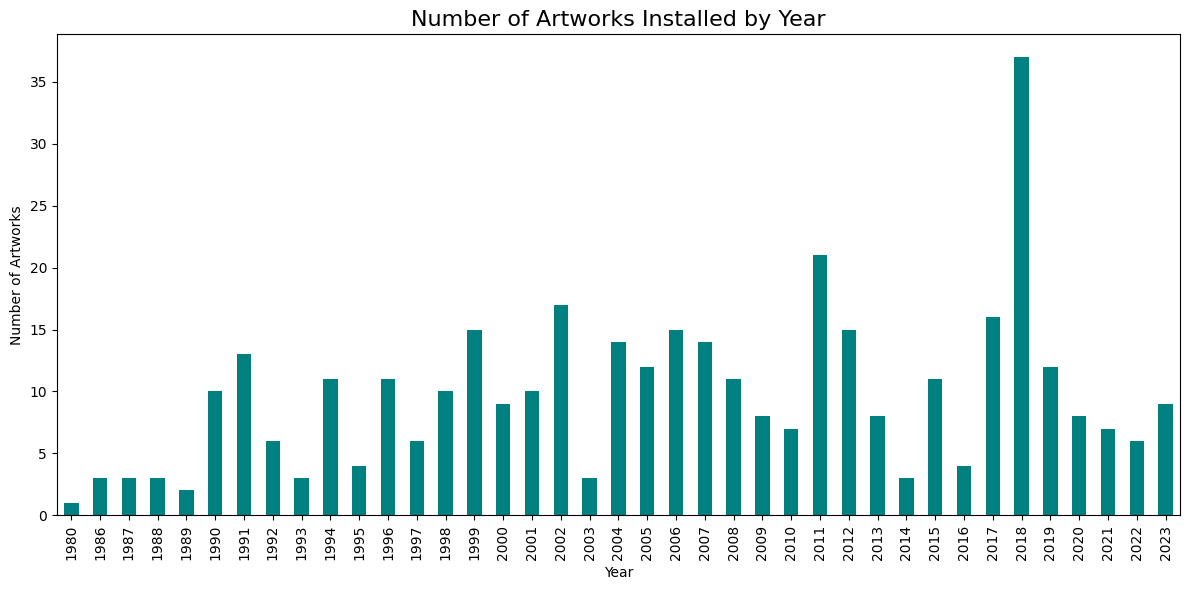

In [14]:
# Group by art_date
art_by_year = mta_art.groupby('art_date').size()

# Plot
plt.figure(figsize=(12, 6))
art_by_year.plot(kind='bar', color='teal')
plt.title('Number of Artworks Installed by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Artworks')
plt.tight_layout()
plt.show()

Observation:  
- Year 2018 saw the highest number of artwork installations (35+), almost double than the number in other individual years.
- This trend however didn't continue, with the number falling below 15 in each of the subsequent years (2019-2023).

### 4.c.ii. Yearwise Artworks Installations - drilling down by Agency

In [15]:
# Agency-wise arts per year
arts_per_year_agency = mta_art.pivot_table(
    index='art_date',
    columns='agency',
    values='art_title',
    aggfunc='count',
    fill_value=0
)

# Plot stacked bar chart
arts_per_year_agency.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='Paired' 
)

# Plot
plt.title('Number of Artworks Installed by Year and Agency', fontsize=16)
plt.xlabel('Year', size=15)
plt.ylabel('Number of Artworks', size=15)
plt.yticks(size=15)
plt.xticks(size=12)
plt.legend(title='Agency', loc='upper left')
plt.tight_layout()
plt.show()

Observations:  
- NYCT which appeared as the major artwork agency clearly dominates across the years.
- In the year 2018, LIRR agency shows a considerable increase in their artwork installations, after NYC.

### 4.d. Which art material were most used in the record high artworks in the year 2018?

Top keywords after cleaning: ['glass', 'mosaic', 'steel', 'ceramic', 'tile', 'marble']
material_category
glass                                  29
steel                                   4
mosaic                                  3
powder-coated aluminum fence panels     1
Name: count, dtype: int64


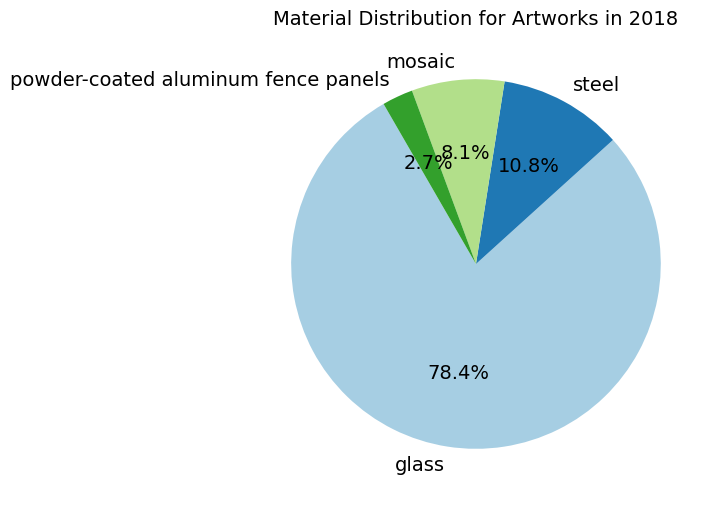

In [16]:
# Filter by year 2018 (the highest number of artwork installations)
arts_2018 = mta_art[mta_art['art_date'] == 2018]

# Clean text and split
stopwords = {'and', 'on', 'of', 'with'}
all_words = (
    " ".join(arts_2018['art_material'].str.lower())
    .replace(";", " ")
    .replace(",", " ")
    .replace("-", " ")
    .split()
)

# Filter out stopwords
filtered_words = [w for w in all_words if w not in stopwords]

# Word frequencies
word_counts = Counter(filtered_words)

# Merge synonyms manually for very common cases (minimal mapping)
merge_map = {
    'stainless': 'steel',
    'steel': 'steel',
    'laminated': 'glass'
    # 'mosaic/glass': 'glass',
}

# Apply merge
normalized_words = [merge_map.get(w, w) for w in filtered_words]
normalized_counts = Counter(normalized_words)

# Top keywords (after merge)
top_keywords = [word for word, _ in normalized_counts.most_common(6)]
print("Top keywords after cleaning:", top_keywords)

# Function to categorise
def auto_categorize(material):
    material = material.lower()
    # Normalise words in material using merge_map
    for old, new in merge_map.items():
        if old in material:
            return new
    # If no match in merge_map, check for top keywords
    for keyword in top_keywords:
        if keyword in material:
            return keyword
    return material

arts_2018 = mta_art[mta_art['art_date'] == 2018].copy()

# Apply categorisation
arts_2018['material_category'] = arts_2018['art_material'].str.lower().apply(auto_categorize)

# Count and plot
category_counts = arts_2018['material_category'].value_counts()

print(category_counts)

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=120,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 14}
)
plt.title('Material Distribution for Artworks in 2018', fontsize=14)
plt.show()

Observations:  
- The most common art material in 2018 was Glass, being used in more than 78% of the artworks in that year.
- Steel and Mosaic were the other used art materials that year.

### 4.e. Which stations have the most number of artworks?

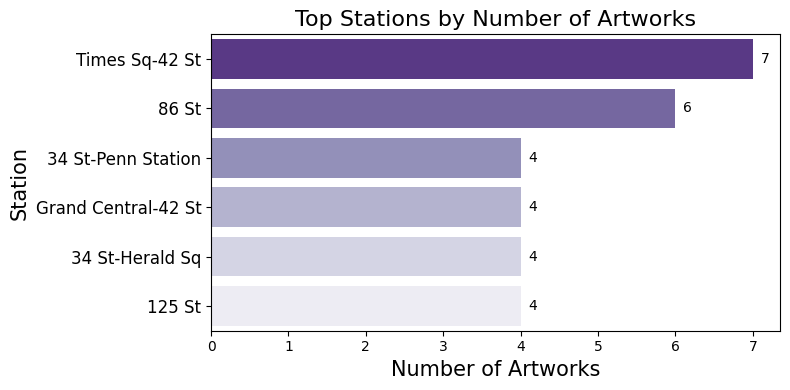

In [17]:
# Count artworks per station
station_counts = mta_art['station_name'].value_counts()

# Define N and get cutoff value
N = 5
cutoff = station_counts.iloc[N-1]  # the count at rank N

# Include all stations with count >= cutoff
top_stations = station_counts[station_counts >= cutoff]

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=top_stations.values, y=top_stations.index, palette='Purples_r', hue=top_stations.index, legend=False)

# Annotate numbers on bars
for i, v in enumerate(top_stations.values):
    plt.text(v + 0.1, i, str(v), va='center')

# Set plot specifications
plt.title('Top Stations by Number of Artworks', fontsize=16)
plt.xlabel('Number of Artworks', size=15)
plt.ylabel('Station', size=15)
plt.yticks(size=12)
plt.tight_layout()
plt.show()


Observations: 
- Times Sq-42 St has the highest number (7) of artworks currently installed (as of 2023), closely followed by 86 St station having 6 artworks.
- Rest all the stations have 4 or less number of artworks.

### 5. Curiosity - Let's actually see some of these artwork images!


Station: Times Sq-42 St (7 artworks)
--------------------------------------------------



Station: 86 St (6 artworks)
--------------------------------------------------


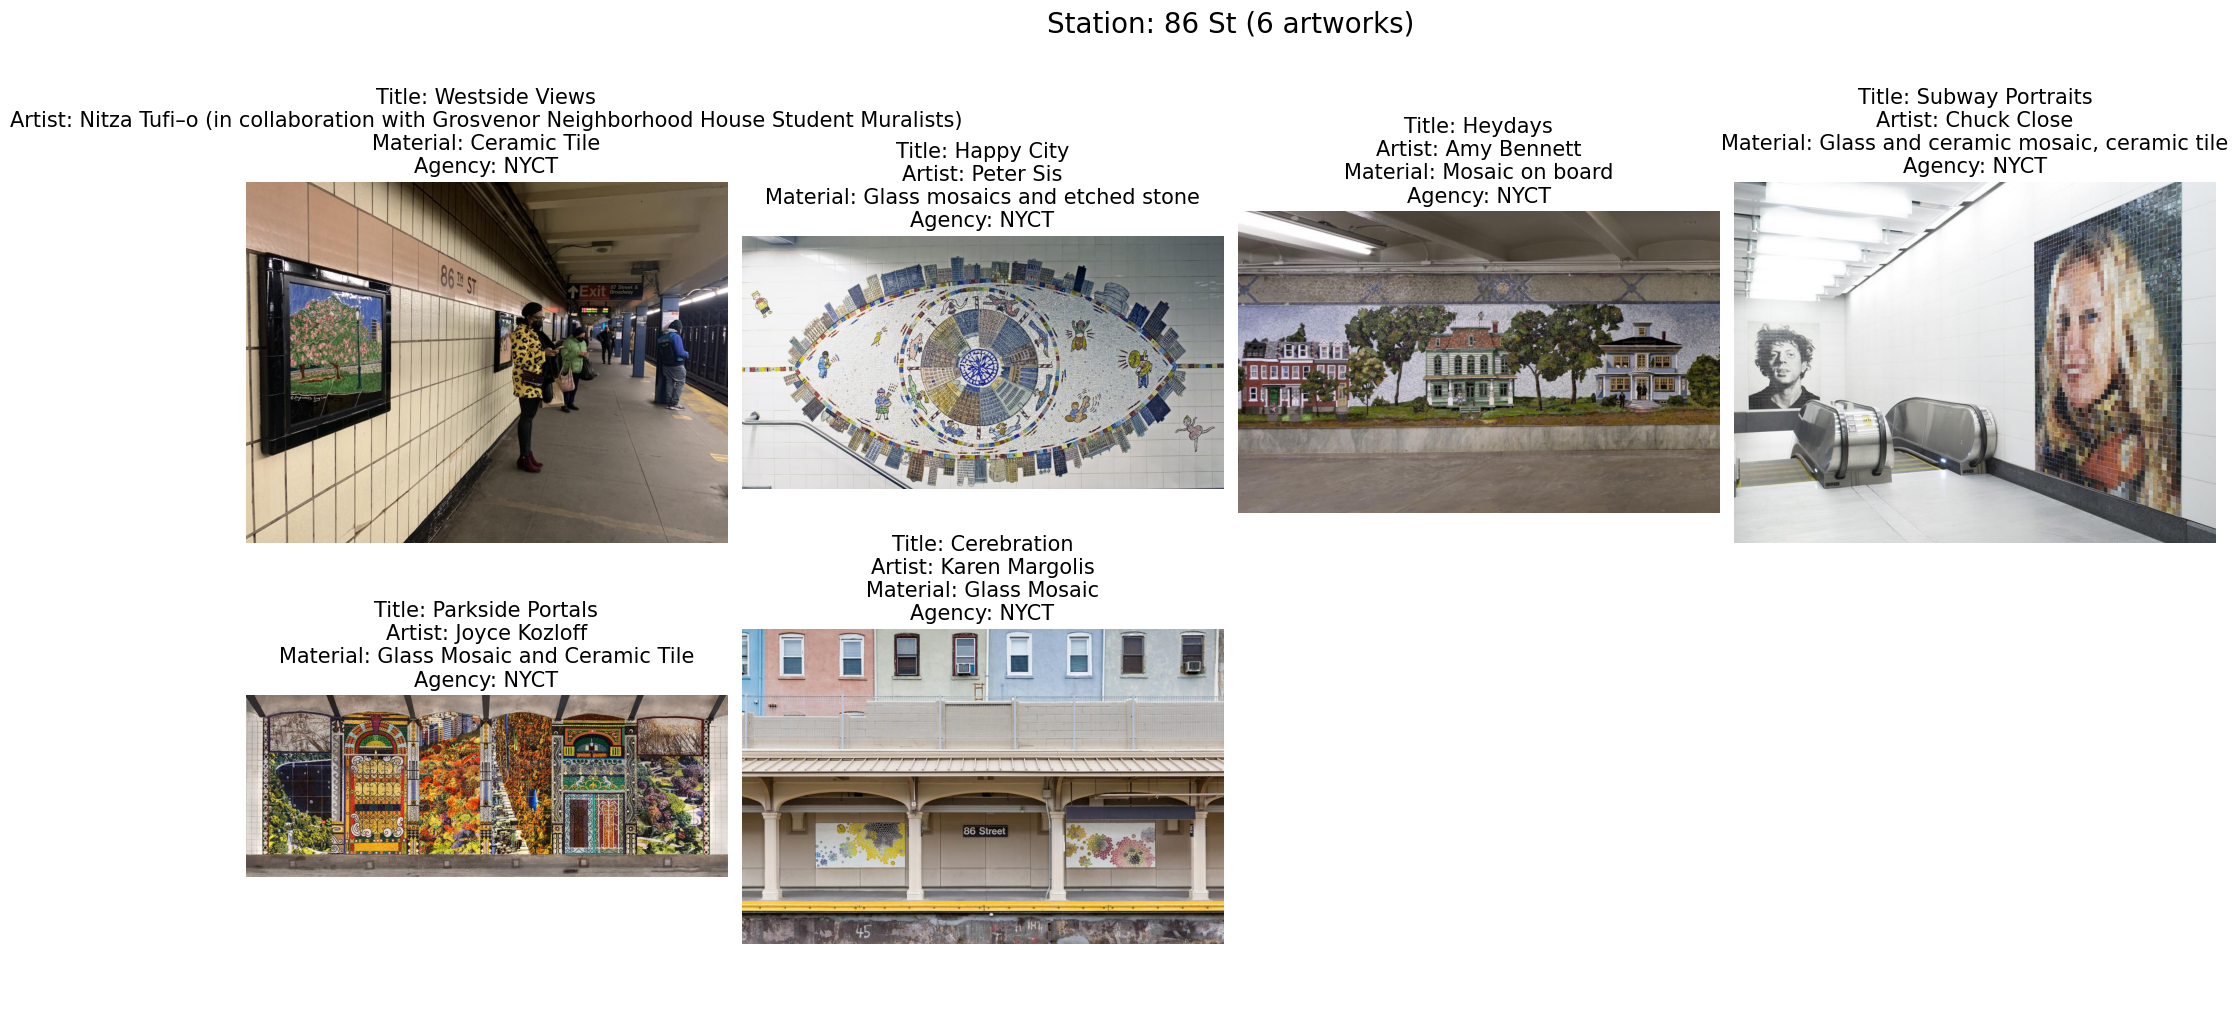

In [ ]:
# The image urls provided in the dataset are HTML webpages, which need to be parsed to fetch the images from them. 

# Function to get direct image URL from MTA art page
def get_mta_image(page_url):
    """
    Extracts the first image URL from a given MTA artwork page.

    Parameters:
        page_url (str): The URL of the webpage to scrape.

    Returns:
        str or None: Direct image URL if found, otherwise None.
    """

    # Set user agent to mimic a browser
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(page_url, headers=headers)

    if response.status_code == 200:
        # Parse HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the first image tag
        img_tag = soup.find('img')
        if img_tag and 'src' in img_tag.attrs:
            img_url = img_tag['src']
            # Fix relative image URL if needed
            if img_url.startswith('//'):
                img_url = 'https:' + img_url
            return img_url
    # Return None if no image is found or request fails
    return None

# Choose top 2 stations by artwork count for display
top_stations = mta_art['station_name'].value_counts().head(2).index

for station in top_stations:
    station_arts = mta_art[(mta_art['station_name'] == station) & mta_art['art_image_link'].notna()]
    n = len(station_arts)
    if n == 0:
        print(f"No images for station: {station}")
        continue
    
    print(f"\nStation: {station} ({n} artworks)\n" + "-"*50)
    
    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    # Common title for the figure 
    fig.suptitle(f"Station: {station} ({n} artworks)", fontsize=20, y=1.02)
    
    for ax in axes[n:]:
        ax.axis('off')
        
    for ax, (_, row) in zip(axes, station_arts.iterrows()):
        img_url = get_mta_image(row['art_image_link'])
        if img_url:
            try:
                img_data = requests.get(img_url).content
                img = Image.open(BytesIO(img_data))
                ax.imshow(img)
            except Exception:
                ax.text(0.5, 0.5, 'Image not available', ha='center', va='center')
        else:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        
        ax.axis('off')
        # Set individual image titles to contain information like title, artist, material, and agency
        ax.set_title(f"Title: {row['art_title']}\nArtist: {row['artist']}\nMaterial: {row['art_material']}\nAgency: {row['agency']}", fontsize=15)
    
    plt.tight_layout()
    plt.show()